In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import sklearn.neighbors

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-a89nej7x because the default path (/home/tsr42/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [20]:
def weights(signed_dists):
    #The weight for a specific point in any localized subset of data is obtained by evaluating 
    # the weight function at the distance between that point and the point of estimation, 
    # after scaling the distance so that the maximum absolute distance over all of the points 
    # in the subset of data is exactly one.
    minscale = None # later, when this breaks, try with 1e-8
    scale = np.max(np.max(signed_dists),0) - np.min(np.min(signed_dists),0)# np.clip(,minscale, None)
    # https://www.itl.nist.gov/div898/handbook/pmd/section1/pmd144.htm
    weight = np.clip((1-(np.abs(signed_dists)/scale)**3)**3,0,1)
    #weight = np.ones(len(signed_dists)).reshape(-1,1)set weights equal for testing
    return weight

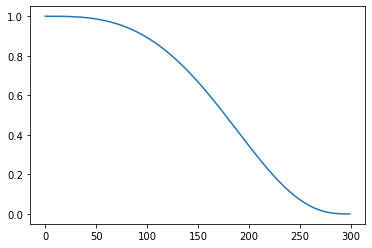

In [21]:
x = np.arange(0,3,0.01)
plt.plot(weights(x))

In [22]:
def safe_divide_arrays(ns,ds):
    res = []
    for i in range(len(ns)):
        n = ns.flatten()[i]
        d = ds.flatten()[i]
        res.append(0 if (np.any(d == 0) or np.any(np.isnan(d))) else n/d)
    return np.array(res)

In [23]:
# learn how to do this ourselves. yay.
def fit_1d_lowess_with_confidence_bounds(x,y,x_target, q):
    x = x.reshape(-1,1)
    y = y.reshape(-1,1)
    N = len(x)
    n_neighbors = int(np.ceil(q*N))
    nbrs = sklearn.neighbors.NearestNeighbors(n_neighbors=n_neighbors, algorithm='ball_tree').fit(x.reshape(-1,1))
    means = []
    stds = []
    # we'll be fitting a new linear model at each of the x_target points
    for xtar in x_target:
        xtar = xtar.reshape(1,1)
        distances, indices = nbrs.kneighbors(xtar)
        indices = indices.flatten()
        signed_distances = (x[indices] - xtar)
        y_subset = y[indices]
        w = weights(signed_distances)
        w = w/np.sum(w)
        wx = np.sqrt(w) * signed_distances
        
        Y  = np.sqrt(w) * y_subset
        X = np.concatenate((np.sqrt(w),wx),axis=1)
        
        n_effective = np.sum(w)/np.sum(np.square(w))
        invcovmat = np.linalg.inv(X.T @ X)
        beta = invcovmat @ X.T @Y
        residual = (Y - X@beta)
        #print(residual/np.sqrt(w))
        residual_variance = np.sum(np.square(residual)) # sum has scale w inside it so it is already like a mean
        # note: R uses len(residual)-2 instead of n_effective-2 here. Weird.
        residual_SE = np.sqrt(residual_variance/(n_effective-2))
        intercept_SE = np.sqrt(invcovmat[0,0]) * residual_SE
        means.append(beta[0,0])
        stds.append(intercept_SE)
    means = np.array(means)
    stds = np.array(stds)
    return(means,stds)

In [24]:
fit_1d_lowess_with_confidence_bounds(np.arange(9),np.array((0,1,2,3,4,3,2,1,0)), np.arange(2),1.)

(array([0.52894537, 1.31863483]), array([0.61622072, 0.59993673]))

In [27]:
X = np.arange(10)
Y = np.array((0,1,3,2,5,10,4,87,9,12))
targxs = np.linspace(0,50,100)
m,s = fit_1d_lowess_with_confidence_bounds(X,Y, targxs,1)

/home/tsr42/anaconda3/envs/curvvaecuda/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in sqrt
/home/tsr42/anaconda3/envs/curvvaecuda/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in sqrt
/home/tsr42/anaconda3/envs/curvvaecuda/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in sqrt
/home/tsr42/anaconda3/envs/curvvaecuda/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in sqrt
/home/tsr42/anaconda3/envs/curvvaecuda/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in sqrt
/home/tsr42/anaconda3/envs/curvvaecuda/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in sqrt
/home/tsr42/anaconda3/envs/curvvaecuda/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in sqrt

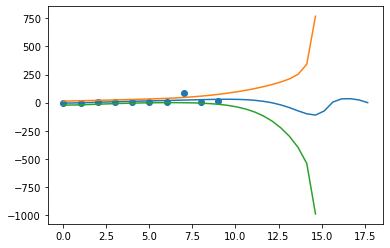

In [28]:
plt.plot(targxs,m)
plt.plot(targxs,m+2*s)
plt.plot(targxs,m-2*s)
plt.scatter(X,Y)